In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
sample_df = pd.read_pickle("data/processed_data/sample_data_with_user_metrics.pkl")

In [3]:
sample_df


,id,created_at,in_reply_to_user_id,public_metrics,edit_history_tweet_ids,text,possibly_sensitive,source,entities,author_id,...,neg_score,pos_neu_neg,compound_score,usernames,user_created_at,user_description,user_profile_image_url,user_followers,user_following,user_tweet_count
0,1586551698285383680,2022-10-30 02:52:56+00:00,1.336194e+18,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[1586551698285383680],@JenRuthGreen @RepMrvan @nwi @dccc Winning! L...,False,Twitter for iPhone,"{'mentions': [{'start': 0, 'end': 13, 'usernam...",742099797923012608,...,0.122,neu,0.7661,Liberaldefeater,2016-06-12T21:02:34.000Z,Liberalism is the #1 threat to the greatest co...,https://pbs.twimg.com/profile_images/155106503...,224,244,14729
1,1586546004756668416,2022-10-30 02:30:18+00:00,2.802080e+07,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",[1586546004756668418],@veeremix @JenRuthGreen @RepMrvan @nwi @dccc 🤣...,False,Twitter for iPhone,"{'mentions': [{'start': 0, 'end': 9, 'username...",742099797923012608,...,0.000,neu,0.0000,Liberaldefeater,2016-06-12T21:02:34.000Z,Liberalism is the #1 threat to the greatest co...,https://pbs.twimg.com/profile_images/155106503...,224,244,14729
2,1586521256530251776,2022-10-30 00:51:58+00:00,7.144638e+17,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[1586521256530251777],@joco0614 @RepLisaBeck @gomcdermott @RepMrvan ...,False,Twitter for iPhone,"{'mentions': [{'start': 0, 'end': 9, 'username...",233693811,...,0.000,neu,0.4215,GaryMillrat,2011-01-03T21:59:32.000Z,"Born and raised Gary, IN. Reproductive Rights ...",https://pbs.twimg.com/profile_images/159815250...,1875,2038,95372
3,1586521120341123072,2022-10-30 00:51:25+00:00,2.802080e+07,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",[1586521120341123074],@veeremix @JenRuthGreen @RepMrvan @nwi @dccc Y...,False,Twitter for iPhone,"{'mentions': [{'start': 0, 'end': 9, 'username...",742099797923012608,...,0.131,neu,-0.3736,Liberaldefeater,2016-06-12T21:02:34.000Z,Liberalism is the #1 threat to the greatest co...,https://pbs.twimg.com/profile_images/155106503...,224,244,14729
4,1586116048738476032,2022-10-28 22:01:49+00:00,1.213124e+18,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[1586116048738476032],@you_republicans @JenRuthGreen @INDems @RepMrv...,False,Twitter for iPhone,"{'mentions': [{'start': 0, 'end': 16, 'usernam...",742099797923012608,...,0.000,neu,0.0000,Liberaldefeater,2016-06-12T21:02:34.000Z,Liberalism is the #1 threat to the greatest co...,https://pbs.twimg.com/profile_images/155106503...,224,244,14729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,1591059880202604544,2022-11-11 13:26:50+00:00,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[1591059880202604544],State can seize all property of Indiana local ...,False,Twitter for Android,"{'urls': [{'start': 71, 'end': 94, 'url': 'htt...",1006860298156945408,...,0.000,neu,0.0000,campbellh26,2018-06-13T11:26:16.000Z,Proudly serving Indiana House of Representativ...,https://pbs.twimg.com/profile_images/143312059...,929,1556,2972
1613,1590563873413033984,2022-11-10 04:35:53+00:00,5.508672e+06,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[1590563873413033985],@nwi 83$ a month isn't shit.,False,Twitter for Android,"{'mentions': [{'start': 0, 'end': 4, 'username...",1206950462467067904,...,0.000,neu,0.4449,,None,None,None,None,None,None
1614,1589826601709367296,2022-11-08 03:46:14+00:00,5.508672e+06,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[1589826601709367296],@nwi Wow you mean if my mom wouldn’t have dran...,False,Twitter for iPhone,"{'mentions': [{'start': 0, 'end': 4, 'username...",990288888521478144,...,0.000,neu,0.5859,ScottWi29218088,2018-04-28T17:57:24.000Z,👍 to your micro aggressions 👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍🤷🏻‍♂️,https://pbs.twimg.com/profile_images/158607921...,227,487,5688
1615,1589811047296561152,2022-11-08 02:44:25+00:00,9.551873e+17,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[158981104729656115

In [4]:
user_ids = list(sample_df["author_id"].value_counts().keys())
active_user_ids = list(sample_df["author_id"][sample_df["usernames"] != ""].value_counts().keys())

In [5]:
heuristic_results = {
    "ratio_over_3": 0,
    "less_than_year_since_creation": 0,
    "over_72_tweets_per_day": 0,
    "no_bio": 0,
    "aggressive_sentiment": 0
}
ratios = []
ages = []
tweets_per_day = []
avg_sentiment = []
uvc = [0, 0, 0, 0, 0, 0]

for user_id in active_user_ids:
    user_tweets = sample_df[sample_df["author_id"] == user_id]
    user_violation_count = 0

    followers = list(user_tweets["user_followers"].values)[0]
    following = list(user_tweets["user_following"].values)[0]
    if type(followers) == str:
        followers = 0
    if followers != 0:
        ratio = following / followers
        ratios.append(ratio)
        if ratio >= 3:
            heuristic_results["ratio_over_3"] += 1
            user_violation_count += 1
    else:
        ratios.append(None)
        heuristic_results["ratio_over_3"] += 1
        user_violation_count += 1
    
    try:
        cr_date = pd.to_datetime(user_tweets["user_created_at"].values[0])
        today = datetime.datetime.now().date()
        age = today - cr_date.date()
        if age.days < 365:
            heuristic_results["less_than_year_since_creation"] += 1
            user_violation_count += 1
        ages.append(age.days)
    except:
        ages.append(None)

    try:
        tweet_count = list(user_tweets["user_tweet_count"].values)[0]
        tpd = tweet_count / age.days
        if tpd >= 72:
            heuristic_results["over_72_tweets_per_day"] += 1
            user_violation_count += 1
        tweets_per_day.append(tpd)
    except:
        tweets_per_day.append(None)
        pass
    
    if list(user_tweets["user_description"].values)[0] == "" or list(user_tweets["user_description"].values)[0] is None:
        heuristic_results["no_bio"] += 1
        user_violation_count += 1

    scores = user_tweets["compound_score"]
    avg = np.average(scores)
    if avg >= 0.5 or avg <= -0.5:
        heuristic_results["aggressive_sentiment"] += 1
        user_violation_count += 1
    avg_sentiment.append(avg)

    uvc[user_violation_count] += 1

    

In [6]:
uvc
print("Heuristic Violation Counts for Sample Data")
for i in range(len(uvc)):
    print(f"{i} violations: {uvc[i]}/{sum(uvc)} ({round(uvc[i] / sum(uvc) * 100, 3)}%)")

Heuristic Violation Counts for Sample Data
0 violations: 231/560 (41.25%)
1 violations: 213/560 (38.036%)
2 violations: 85/560 (15.179%)
3 violations: 29/560 (5.179%)
4 violations: 2/560 (0.357%)
5 violations: 0/560 (0.0%)


In [8]:
h1 = heuristic_results["ratio_over_3"]
h2 = heuristic_results["less_than_year_since_creation"]
h3 = heuristic_results["over_72_tweets_per_day"]
h4 = heuristic_results["no_bio"]
h5 = heuristic_results["aggressive_sentiment"]

print("Thresholds Violated in Sample Data")
print(f"Following/Follower ratio > 3: {h1}/{sum(uvc)}")
print(f"Account created < 1 year ago: {h2}/{sum(uvc)}")
print(f"Average tweets per day > 72: {h3}/{sum(uvc)}")
print(f"No account description: {h4}/{sum(uvc)}")
print(f"Absolute value of average sentiment > 0.5: {h5}/{sum(uvc)}")

Thresholds Violated in Sample Data
Following/Follower ratio > 3: 140/560
Account created < 1 year ago: 84/560
Average tweets per day > 72: 45/560
No account description: 96/560
Absolute value of average sentiment > 0.5: 113/560


Text(0.5, 1.0, 'Average Sentiment versus Following/Follower Ratio for Sample Data')

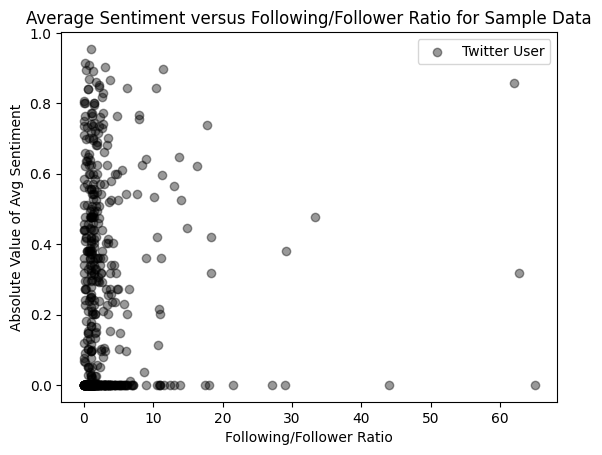

In [145]:
plt.scatter(ratios, np.abs(avg_sentiment), alpha=0.4, color="black", label="Twitter User")
plt.xlabel("Following/Follower Ratio")
plt.ylabel("Absolute Value of Avg Sentiment")
plt.legend()
plt.title("Average Sentiment versus Following/Follower Ratio for Sample Data")

Text(0.5, 1.0, 'Heuristic Violations in Sample Data')

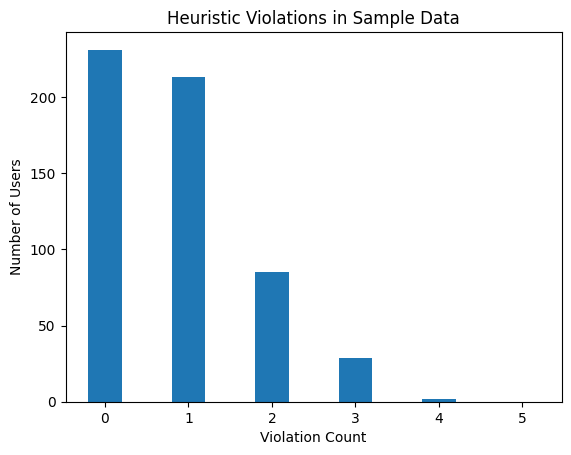

In [21]:
uvc_dict = {
    "0" : uvc[0],
    "1" : uvc[1],
    "2" : uvc[2],
    "3" : uvc[3],
    "4" : uvc[4],
    "5" : uvc[5]
}
keys = list(uvc_dict.keys())
values = list(uvc_dict.values())
plt.bar(keys, values, width = 0.4)
plt.xlabel("Violation Count")
plt.ylabel("Number of Users")
plt.title("Heuristic Violations in Sample Data")